# Imports

In [280]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report 
from sklearn.metrics import plot_roc_curve
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.compose import ColumnTransformer
import time
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import Ridge

## Data Import and Cleaning 

### Import Historic Stats

In [281]:
current_week = int(input("Input Current NFL Week"))
print(current_week)

Input Current NFL Week4
4


In [282]:
years = [2017, 2018, 2019, 2020, 2021]

In [283]:
stats_list = []
for year in years:
    if year != 2021:
        for i in range(1,18):
            name = 'Data/Historic_Stats/'+ str(year) + '_' + str(i) + '.csv'
            stats_list.append(name)
    else:
        for i in range(1, current_week):
            name = 'Data/Historic_Stats/'+ str(year) + '_' + str(i) + '.csv'
            stats_list.append(name)

In [284]:
stats_list[0][-10:-6]

'2017'

In [285]:
len('Data/Historic_Stats/2017_10.csv')

31

In [286]:
historic_stats = pd.DataFrame()
for index, item in enumerate(stats_list):
    df = pd.read_csv(item)
    df = df[['Name', 'Team', 'Week', 'Opponent', 'FantasyPointsPerGameFanDuel', 'FantasyPointsFanDuel']]
    df = df.rename(columns={'FantasyPointsPerGameFanDuel':'FPPG', 'FantasyPointsFanDuel':'Points_Scored'})
    if len(item) == 30:
        df['Year'] = item[-10:-6]
    else: 
        df['Year'] = item[-11:-7]
    historic_stats = historic_stats.append(df)

In [287]:
historic_stats['Year'].value_counts()

2020    19876
2017    19318
2019    19147
2018    19105
2021     3742
Name: Year, dtype: int64

### Import Historic Projections 

In [288]:
proj_list = []
for year in years:
    if year != 2021:
        for i in range(1,18):
            name = 'Data/Historic_Proj/'+ str(year) + '_' + str(i) + '.csv'
            proj_list.append(name)
    else:
        for i in range(1, current_week):
            name = 'Data/Historic_Proj/'+ str(year) + '_' + str(i) + '.csv'
            proj_list.append(name)

In [289]:
len('Data/Historic_Proj/2017_10.csv')

30

In [290]:
historic_projections = pd.DataFrame()
for item in proj_list:
    df = pd.read_csv(item)
    df = df[['Name', 'Position', 'Week', 'Team','UpcomingOpponentPositionRank', 'FantasyPointsFanDuel', 'OperatorSalary']]
    df = df.rename(columns={'UpcomingOpponentPositionRank':'OPRNK', 'FantasyPointsFanDuel': 'Projected', 'OperatorSalary': 'Salary'})
    if len(item) == 29:
        df['Year'] = item[-10:-6]
    else:
        df['Year'] = item[-11:-7]
    historic_projections = historic_projections.append(df)

In [291]:
merged_data = historic_stats.merge(historic_projections, how='inner', on=['Name', 'Week', 'Year', 'Team'])

In [292]:
merged_data

,Name,Team,Week,Opponent,FPPG,Points_Scored,Year,Position,OPRNK,Projected,Salary
0,Kareem Hunt,KC,1,NE,43.1,43.10,2017,RB,3.0,10.73,6400
1,Alex Smith,KC,1,NE,31.0,31.02,2017,QB,11.0,14.69,6900
2,Matthew Stafford,DET,1,ARI,28.1,28.08,2017,QB,12.0,16.13,7600
3,Jacksonville Jaguars,JAX,1,HOU,28.0,28.00,2017,DST,NaN,6.40,4100
4,Los Angeles Rams,LAR,1,IND,28.0,28.00,2017,DST,NaN,7.90,4600
...,...,...,...,...,...,...,...,...,...,...,...
26467,Kansas City Chiefs,KC,3,LAC,0.0,0.00,2021,DST,NaN,7.90,3700
26468,Tampa Bay Buccaneers,TB,3,LAR,0.0,0.00,2021,DST,NaN,7.20,3900
26469,Dyami Brown,WAS,3,BUF,-0.4,-0.40,2021,WR,3.0,5.17,4800
26470,Ashton Dulin,IND,3,TEN,-0.7,-0.70,2021,WR,32.0,1.15,4500


In [293]:
merged_data = merged_data.drop(merged_data[(merged_data['Name'] == 'Chris Thompson') & (merged_data['Team'] == 'HOU')].index)

I noticed there were two Chris Thompsons for 2017 (one on Washington and one on Houston) so I decided to drop the Houston Chris Thompson because it would interfere with the groupbys later in the process

In [294]:
merged_data = merged_data[merged_data['Position'] != 'DST']
merged_data = merged_data[merged_data['Position'] != 'K']
merged_data = merged_data[merged_data['Position'] != 'LB']
merged_data = merged_data[merged_data['Position'] != 'DB']

In [295]:
merged_data['Position'].value_counts()

WR    9070
RB    6746
TE    5649
QB    2440
Name: Position, dtype: int64

In [296]:
merged_data.duplicated().sum()

38

In [297]:
merged_data[merged_data.duplicated(keep=False) == True]

,Name,Team,Week,Opponent,FPPG,Points_Scored,Year,Position,OPRNK,Projected,Salary
1303,Alex Smith,KC,4,WAS,27.3,27.32,2017,QB,7.0,15.78,7600
1304,Alex Smith,KC,4,WAS,27.3,27.32,2017,QB,7.0,15.78,7600
1316,Travis Kelce,KC,4,WAS,20.9,20.90,2017,TE,28.0,10.66,7400
1317,Travis Kelce,KC,4,WAS,20.9,20.90,2017,TE,28.0,10.66,7400
1318,Kirk Cousins,WAS,4,KC,20.6,20.60,2017,QB,9.0,16.00,7500
...,...,...,...,...,...,...,...,...,...,...,...
2163,Chester Rogers,IND,6,TEN,0.0,0.00,2017,WR,27.0,3.19,4500
2172,Eric Weems,TEN,6,IND,0.0,0.00,2017,WR,31.0,0.64,4500
2173,Eric Weems,TEN,6,IND,0.0,0.00,2017,WR,31.0,0.64,4500
2191,Brandon Williams,IND,6,TEN,0.0,0.00,2017,TE,9.0,0.76,4500


In [298]:
merged_data = merged_data.drop_duplicates()

In [299]:
merged_data['Year'].value_counts()

2020    6450
2019    5645
2018    5551
2017    5025
2021    1196
Name: Year, dtype: int64

In [300]:
grouped = merged_data.groupby(['Name','Year','Week']).sum()

It looks like the Fantasy Points Per Game column is just the points scored column right now so we need to calculate that manually

In [301]:
grouped['Games_Played'] = 1

In [302]:
new_df = grouped.groupby(level=[0,1]).cumsum().reset_index()

In [303]:
new_df['Fantasy_PPG'] = round(new_df['Points_Scored'] / new_df['Games_Played'], 1)

In [304]:
new_df['Fantasy_PPG'] = new_df.groupby(['Name', 'Year'])['Fantasy_PPG'].shift()

In [305]:
new_df = new_df[['Name', 'Year', 'Week', 'Fantasy_PPG', 'Games_Played']]

In [306]:
new_df

,Name,Year,Week,Fantasy_PPG,Games_Played
0,A.J. Brown,2019,1,NaN,1
1,A.J. Brown,2019,2,11.5,2
2,A.J. Brown,2019,3,7.8,3
3,A.J. Brown,2019,4,5.5,4
4,A.J. Brown,2019,5,9.8,5
...,...,...,...,...,...
23851,Zay Jones,2020,15,1.8,14
23852,Zay Jones,2020,16,1.8,15
23853,Zay Jones,2020,17,1.7,16
23854,Zay Jones,2021,2,NaN,1


In [307]:
new_df['FPPG'] = round(new_df.groupby(['Year','Name'])['Fantasy_PPG'].transform(lambda x: x.fillna(x.mean())), 1)

In [308]:
new_df = new_df.drop('Fantasy_PPG', axis=1)

In [309]:
new_df = new_df.dropna()

In [310]:
merged_data = merged_data.drop('FPPG', axis=1)

In [311]:
merged_data = pd.merge(merged_data, new_df, how='inner', on=['Name','Year','Week'])

In [312]:
merged_data['Week'].value_counts()

2     1909
3     1896
1     1825
14    1491
15    1478
13    1448
16    1407
4     1398
12    1369
6     1339
10    1283
9     1271
11    1269
17    1177
5     1056
7     1025
8     1022
Name: Week, dtype: int64

In [313]:
merged_data[merged_data['Name'] == 'Tom Brady']

,Name,Team,Week,Opponent,Points_Scored,Year,Position,OPRNK,Projected,Salary,Games_Played,FPPG
65,Tom Brady,NE,1,KC,10.68,2017,QB,10.0,20.06,8900,1,20.8
363,Tom Brady,NE,2,NO,30.78,2017,QB,27.0,22.17,9200,2,10.7
733,Tom Brady,NE,3,HOU,35.72,2017,QB,5.0,18.70,9400,3,20.7
1130,Tom Brady,NE,4,CAR,20.48,2017,QB,7.0,20.62,9500,4,25.7
1492,Tom Brady,NE,5,TB,13.62,2017,QB,30.0,21.87,9500,5,24.4
...,...,...,...,...,...,...,...,...,...,...,...,...
21327,Tom Brady,TB,15,ATL,23.40,2020,QB,32.0,20.34,7900,14,20.4
21718,Tom Brady,TB,16,DET,29.92,2020,QB,29.0,21.29,8000,15,20.6
22135,Tom Brady,TB,17,ATL,31.26,2020,QB,32.0,20.70,8400,16,21.2
22855,Tom Brady,TB,2,ATL,29.64,2021,QB,28.0,23.52,8200,1,29.6


In [314]:
merged_data['Team'].value_counts().index

Index(['ATL', 'KC', 'BUF', 'DEN', 'SF', 'NE', 'LV', 'TEN', 'PIT', 'MIA', 'NYJ',
       'NO', 'DAL', 'CLE', 'TB', 'NYG', 'GB', 'SEA', 'PHI', 'CAR', 'BAL',
       'ARI', 'IND', 'CIN', 'LAC', 'CHI', 'WAS', 'MIN', 'JAX', 'LAR', 'HOU',
       'DET'],
      dtype='object')

### Merge With Betting Data

In [315]:
betting_data_home = pd.read_excel('Data/clean_nfl_historic_betting_data.xlsx', sheet_name=2)

In [316]:
betting_data_away = pd.read_excel('Data/clean_nfl_historic_betting_data.xlsx', sheet_name=1)

In [317]:
betting_data = pd.concat([betting_data_home, betting_data_away])

In [318]:
betting_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8142 entries, 0 to 4070
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               8142 non-null   datetime64[ns]
 1   Team               8142 non-null   object        
 2   Line Close         3870 non-null   float64       
 3   Total Score Close  3870 non-null   float64       
 4   Team Proj          3870 non-null   float64       
 5   Week               3870 non-null   float64       
 6   Home / Away        3870 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 508.9+ KB


In [319]:
betting_data['Year'] = betting_data['Date'].dt.year

In [320]:
betting_data['Year'] = betting_data['Year'].astype(str)

In [321]:
betting_data['Year'].value_counts()

2017    566
2012    566
2014    534
2011    534
2013    534
2007    534
2008    534
2010    534
2018    534
2019    534
2016    534
2006    512
2020    502
2009    502
2015    502
2021    185
1905      1
Name: Year, dtype: int64

In [322]:
betting_data = betting_data[betting_data['Week'] != 0]

In [323]:
merged_data = merged_data.merge(betting_data, how='inner', on=['Team', 'Week', 'Year'])

In [324]:
merged_data = merged_data[merged_data['Week'] != 17]

In [325]:
historic_dome_teams = ['ATL', 'HOU', 'DAL', 'IND', 'ARI', 'NO', 'DET', 'MIN']

In [326]:
merged_data["Dome"] = np.where((merged_data['Team'].isin(historic_dome_teams)) & (merged_data['Home / Away'] == "Home"), "Dome", np.where((merged_data['Opponent'].isin(historic_dome_teams)) & (merged_data['Home / Away'] == "Away"), "Dome", 'Outside'))

In [327]:
merged_data['Dome'].value_counts()

Outside    16848
Dome        5629
Name: Dome, dtype: int64

In [328]:
merged_data = merged_data.rename(columns={'Line Close':'line_close', 'Total Score Close':'over_under'})
merged_data = merged_data.rename(columns={'Team Proj':'team_proj', 'Home / Away':'home_away'})

## Modeling

In [329]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22477 entries, 0 to 23258
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Name           22477 non-null  object        
 1   Team           22477 non-null  object        
 2   Week           22477 non-null  int64         
 3   Opponent       22477 non-null  object        
 4   Points_Scored  22477 non-null  float64       
 5   Year           22477 non-null  object        
 6   Position       22477 non-null  object        
 7   OPRNK          22450 non-null  float64       
 8   Projected      22450 non-null  float64       
 9   Salary         22477 non-null  int64         
 10  Games_Played   22477 non-null  int64         
 11  FPPG           22477 non-null  float64       
 12  Date           22477 non-null  datetime64[ns]
 13  line_close     22477 non-null  float64       
 14  over_under     22477 non-null  float64       
 15  team_proj      2247

In [330]:
df = merged_data.copy()

In [331]:
df['games_missed'] = df['Week'] - df['Games_Played']

In [332]:
from sklearn.preprocessing import OrdinalEncoder
home = df[['home_away']]
encoder_home = OrdinalEncoder()
encoder_home.fit(home)
home_encoded = encoder_home.transform(home)
home_encoded = home_encoded.flatten()
df['home_away'] = home_encoded

In [333]:
dome = df[['Dome']]
encoder_dome = OrdinalEncoder()
encoder_dome.fit(dome)
dome_encoded = encoder_dome.transform(dome)
dome_encoded = dome_encoded.flatten()
df['Dome'] = dome_encoded

In [334]:
df = df.drop('Date', axis=1)

In [335]:
df = df.dropna()

In [336]:
categoricals = ['Team', 'Name','Week', 'Opponent', 'Position', 'Year']
df_no_cats = df.drop(categoricals, axis=1)

In [337]:
df_cats = df[categoricals]
df_cats = df_cats.drop('Year', axis=1)

In [338]:
df_no_cats['Points'] = df_no_cats['Points_Scored']
df_no_cats = df_no_cats.drop('Points_Scored', axis=1)

In [339]:
multiple_formula = 'Points ~ Projected'
multiple_model = ols(multiple_formula, df_no_cats).fit()
multiple_model_summary = multiple_model.summary()
multiple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Points   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                 2.481e+04
Date:                Fri, 01 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:37:46   Log-Likelihood:                -68860.
No. Observations:               22450   AIC:                         1.377e+05
Df Residuals:                   22448   BIC:                         1.377e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2275      0.051      4.429      0.000       0.127       0.328
Projected      0.9761      0.006    157.517      0.000       0.964       0.988
==============================================================================
Omnibus:                     5410.710   Durbin-Watson:                   1.502
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18087.178
Skew:                           1.209   Prob(JB):                         0.00
Kurtosis:                       6.672   Cond. No.                         12.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [340]:
correlation_matrix = df_no_cats.corr()

In [341]:
df_corr=correlation_matrix.abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
df_corr.drop_duplicates(inplace=True)
df_corr = df_corr[df_corr['cc'] < 1.0000]
df_corr.head(10)

,cc
pairs,
"(Salary, Projected)",0.908470
"(FPPG, Projected)",0.902170
"(Salary, FPPG)",0.870365
"(line_close, team_proj)",0.813075
"(Points, Projected)",0.724573
"(Points, FPPG)",0.679089
"(Salary, Points)",0.668020
"(over_under, team_proj)",0.579055
"(home_away, line_close)",0.272367


In [342]:
pf = PolynomialFeatures(degree=2)

X = df_no_cats


pf.fit(X)
pdf = pd.DataFrame(pf.transform(X), columns=pf.get_feature_names())
pdf
corr_df = pdf.corr()
corr_df[corr_df['x11'] > .7]['x11']

x1        0.724573
x11       1.000000
x0 x11    0.821539
x1 x2     0.714023
x1 x6     0.719505
x1 x7     0.711273
x1 x11    0.899388
x2 x11    0.973700
x3 x11    0.790775
x4 x11    0.858177
x6 x11    0.992078
x7 x11    0.980204
x9 x11    0.775621
x11^2     0.916575
Name: x11, dtype: float64

In [343]:
categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(categories='auto',
                          sparse=False))
])

In [344]:
cat_transformed = categorical_pipeline.fit_transform(df_cats)

In [345]:
cat_encoded = pd.DataFrame(

    cat_transformed,

    columns=categorical_pipeline.named_steps['ohe'].get_feature_names(df_cats.columns),
 
    index=df.index
)

In [346]:
cat_encoded

,Team_ARI,Team_ATL,Team_BAL,Team_BUF,Team_CAR,Team_CHI,Team_CIN,Team_CLE,Team_DAL,Team_DEN,...,Opponent_PIT,Opponent_SEA,Opponent_SF,Opponent_TB,Opponent_TEN,Opponent_WAS,Position_QB,Position_RB,Position_TE,Position_WR
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23254,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23255,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
23256,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23257,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [347]:
from sklearn.linear_model import LinearRegression
y = df['Points_Scored']
X = df_no_cats[['OPRNK', 'Projected', 'FPPG', 'home_away', 'team_proj', 'Salary', 'Dome']]

model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.5290762655116974

In [348]:
X = pd.concat([X.reset_index(drop=True), cat_encoded.reset_index(drop=True)], axis=1)

In [349]:
model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.5527346375619995

In [350]:
X['QB_proj'] = X['Position_QB'] * X['Projected'] * X['OPRNK']
X['RB_proj'] = X['Position_RB'] * X['Projected'] * X['OPRNK']
X['WR_proj'] = X['Position_WR'] * X['Projected'] * X['OPRNK']
X['TE_proj'] = X['Position_TE'] * X['Projected'] * X['OPRNK']

In [351]:
model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.5535471772659892

In [352]:
clf = Ridge()
clf.fit(X, y)
clf.score(X,y)

0.5529637446066912

In [353]:
preds = model.predict(X)

In [354]:
mean_squared_error(df['Points_Scored'], preds)

25.397635295898105

In [355]:
mean_squared_error(df['Points_Scored'], df['Projected'])

27.04579983073496

In [356]:
residual = y - model.predict(X)

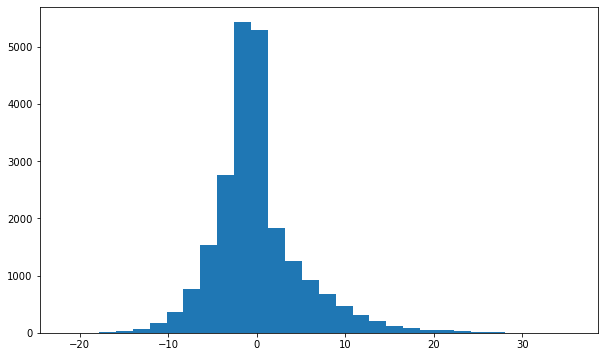

In [357]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(residual, bins=30);

### Get Current Week Projections Ready for Model

In [428]:
current_projections = pd.read_csv('Data/current_week_projections.csv', index_col=0)

In [429]:
current_projections = current_projections[['Name', 'Position', 'Week', 'Opponent','Team','UpcomingOpponentPositionRank', 'FantasyPointsFanDuel', 'OperatorSalary']]
current_projections = current_projections.rename(columns={'UpcomingOpponentPositionRank':'OPRNK', 'FantasyPointsFanDuel': 'Projected', 'OperatorSalary': 'Salary'})

In [430]:
stats_2021 = merged_data[merged_data['Year'] == '2021']

In [431]:
stats_2021 = stats_2021[stats_2021['Week'] == (current_week-1)]

In [432]:
stats_2021['Fantasy_PPG'] = round((stats_2021['FPPG']*(current_week-1) + stats_2021['Points_Scored']) / current_week, 1)

In [433]:
stats_2021

,Name,Team,Week,Opponent,Points_Scored,Year,Position,OPRNK,Projected,Salary,Games_Played,FPPG,Date,line_close,over_under,team_proj,home_away,Dome,Fantasy_PPG
22872,Josh Allen,BUF,3,WAS,37.22,2021,QB,20.0,23.28,8000,3,17.4,2021-09-01,-7.0,45.5,26.25,Home,Outside,22.4
22873,Emmanuel Sanders,BUF,3,WAS,23.90,2021,WR,23.0,9.74,5200,3,6.5,2021-09-01,-7.0,45.5,26.25,Home,Outside,10.8
22874,Zack Moss,BUF,3,WAS,16.60,2021,RB,7.0,5.98,5400,2,14.4,2021-09-01,-7.0,45.5,26.25,Home,Outside,15.0
22875,Cole Beasley,BUF,3,WAS,15.30,2021,WR,23.0,9.99,5400,3,7.8,2021-09-01,-7.0,45.5,26.25,Home,Outside,9.7
22876,Dawson Knox,BUF,3,WAS,12.90,2021,TE,14.0,6.18,5400,3,7.4,2021-09-01,-7.0,45.5,26.25,Home,Outside,8.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23254,Damiere Byrd,CHI,3,CLE,0.00,2021,WR,17.0,2.90,4800,2,0.0,2021-09-01,7.0,45.5,19.25,Away,Outside,0.0
23255,Khalil Herbert,CHI,3,CLE,0.00,2021,RB,8.0,0.65,4500,2,0.0,2021-09-01,7.0,45.5,19.25,Away,Outside,0.0
23256,Jimmy Graham,CHI,3,CLE,0.00,2021,TE,26.0,3.15,4500,2,0.0,2021-09-01,7.0,45.5,19.25,Away,Outside,0.0
23257,J.P. Holtz,CHI,3,CLE,0.00,2021,TE,26.0,0.33,4000,2,0.0,2021-09-01,7.0,45.5,19.25,Away,Outside,0.0


In [434]:
stats_2021 = stats_2021.drop('FPPG', axis=1)

In [435]:
stats_2021 = stats_2021.rename(columns={'Fantasy_PPG': 'FPPG'})

In [436]:
stats_2021 = stats_2021[['Name', 'FPPG']]

In [437]:
stats_2021

,Name,FPPG
22872,Josh Allen,22.4
22873,Emmanuel Sanders,10.8
22874,Zack Moss,15.0
22875,Cole Beasley,9.7
22876,Dawson Knox,8.8
...,...,...
23254,Damiere Byrd,0.0
23255,Khalil Herbert,0.0
23256,Jimmy Graham,0.0
23257,J.P. Holtz,0.0


In [438]:
current_projections = current_projections.merge(stats_2021, how='inner', on=['Name'])

In [439]:
current_projections = current_projections.drop_duplicates()

In [440]:
current_projections

,Name,Position,Week,Opponent,Team,OPRNK,Projected,Salary,FPPG
0,Derrick Henry,RB,4,NYJ,TEN,28.0,19.46,10200,24.7
1,Alvin Kamara,RB,4,NYG,NO,22.0,18.25,9000,12.9
2,Patrick Mahomes,QB,4,PHI,KC,9.0,24.55,8700,28.1
3,Cooper Kupp,WR,4,ARI,LAR,23.0,17.39,8600,30.8
4,Josh Allen,QB,4,HOU,BUF,20.0,25.38,8500,22.4
...,...,...,...,...,...,...,...,...,...
308,Patrick Scales,TE,4,DET,CHI,NaN,NaN,4000,0.0
309,Andrew DePaola,TE,4,CLE,MIN,NaN,NaN,4000,0.0
310,James Winchester,TE,4,PHI,KC,NaN,NaN,4000,0.0
311,Tyler Ott,TE,4,SF,SEA,NaN,NaN,4000,0.0


In [447]:
betting_home = pd.read_excel('Data/clean_nfl_historic_betting_data.xlsx', sheet_name=2)
betting_data_away = pd.read_excel('Data/clean_nfl_historic_betting_data.xlsx', sheet_name=1)
betting_data = pd.concat([betting_data_home, betting_data_away])
betting_data['Date'] = betting_data['Date'].dt.year
betting_data = betting_data[betting_data['Date'] == 2021]
betting_data = betting_data[betting_data['Week'] == current_week]

In [449]:
current_projections = current_projections.merge(betting_data, how='inner', on=['Team', 'Week'])

In [450]:
current_projections

,Name,Position,Week,Opponent,Team,OPRNK,Projected,Salary,FPPG,Date,Line Close,Total Score Close,Team Proj,Home / Away
0,Derrick Henry,RB,4,NYJ,TEN,28.0,19.46,10200,24.7,2021,-6.5,44.5,25.5,Away
1,Ryan Tannehill,QB,4,NYJ,TEN,3.0,18.53,7500,17.0,2021,-6.5,44.5,25.5,Away
2,A.J. Brown,WR,4,NYJ,TEN,4.0,0.00,6800,7.1,2021,-6.5,44.5,25.5,Away
3,Julio Jones,WR,4,NYJ,TEN,4.0,0.00,6700,9.1,2021,-6.5,44.5,25.5,Away
4,Nick Westbrook-Ikhine,WR,4,NYJ,TEN,4.0,5.20,5300,3.8,2021,-6.5,44.5,25.5,Away
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,Keelan Cole,WR,4,TEN,NYJ,31.0,3.63,4500,1.0,2021,6.5,44.5,19.0,Home
309,Jeff Smith,WR,4,TEN,NYJ,31.0,0.00,4500,2.0,2021,6.5,44.5,19.0,Home
310,Trevon Wesco,TE,4,TEN,NYJ,1.0,0.44,4100,0.0,2021,6.5,44.5,19.0,Home
311,Ryan Griffin,TE,4,TEN,NYJ,1.0,2.88,4000,2.3,2021,6.5,44.5,19.0,Home


In [451]:
current_projections = current_projections.dropna()

In [452]:
current_dome_teams = ['ATL', 'HOU', 'DAL', 'IND', 'ARI', 'NO', 'DET', 'MIN', 'LV', 'LAC', 'LAR']

In [453]:
current_projections["Dome"] = np.where((current_projections['Team'].isin(current_dome_teams)) & (current_projections['Home / Away'] == "Home"), "Dome", np.where((current_projections['Opponent'].isin(current_dome_teams)) & (current_projections['Home / Away'] == "Away"), "Dome", 'Outside'))

<ipython-input-453-cbc2601aff7d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_projections["Dome"] = np.where((current_projections['Team'].isin(current_dome_teams)) & (current_projections['Home / Away'] == "Home"), "Dome", np.where((current_projections['Opponent'].isin(current_dome_teams)) & (current_projections['Home / Away'] == "Away"), "Dome", 'Outside'))


In [454]:
current_projections.duplicated().sum()

0

In [455]:
current_projections = current_projections.rename(columns={'Line Close':'line_close', 'Total Score Close':'over_under'})
current_projections = current_projections.rename(columns={'Team Proj':'team_proj', 'Home / Away':'home_away'})

In [456]:
current_projections['Dome'].value_counts()

Outside    188
Dome       120
Name: Dome, dtype: int64

In [457]:
df = current_projections.copy()

In [458]:
from sklearn.preprocessing import OrdinalEncoder
home = df[['home_away']]
encoder_home = OrdinalEncoder()
encoder_home.fit(home)
home_encoded = encoder_home.transform(home)
home_encoded = home_encoded.flatten()
df['home_away'] = home_encoded

In [459]:
dome = df[['Dome']]
encoder_dome = OrdinalEncoder()
encoder_dome.fit(dome)
dome_encoded = encoder_dome.transform(dome)
dome_encoded = dome_encoded.flatten()
df['Dome'] = dome_encoded

In [460]:
df = df.drop('Date', axis=1)

In [461]:
df = df.dropna()

In [462]:
categoricals = ['Team', 'Name','Week', 'Opponent', 'Position']
df_no_cats = df.drop(categoricals, axis=1)

In [463]:
df_cats = df[categoricals]

In [464]:
cat_transformed = categorical_pipeline.transform(df_cats)

In [465]:
cat_encoded = pd.DataFrame(

    cat_transformed,

    columns=categorical_pipeline.named_steps['ohe'].get_feature_names(df_cats.columns),
 
    index=df.index
)

In [466]:
cat_encoded

,Team_ARI,Team_ATL,Team_BAL,Team_BUF,Team_CAR,Team_CHI,Team_CIN,Team_CLE,Team_DAL,Team_DEN,...,Opponent_PIT,Opponent_SEA,Opponent_SF,Opponent_TB,Opponent_TEN,Opponent_WAS,Position_QB,Position_RB,Position_TE,Position_WR
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [467]:
X_proj = df_no_cats[['OPRNK', 'Projected', 'FPPG', 'home_away', 'team_proj', 'Salary', 'Dome']]

In [468]:
X_proj = pd.concat([X_proj.reset_index(drop=True), cat_encoded.reset_index(drop=True)], axis=1)

In [469]:
X_proj['QB_proj'] = X_proj['Position_QB'] * X_proj['Projected'] * X_proj['OPRNK']
X_proj['RB_proj'] = X_proj['Position_RB'] * X_proj['Projected'] * X_proj['OPRNK']
X_proj['WR_proj'] = X_proj['Position_WR'] * X_proj['Projected'] * X_proj['OPRNK']
X_proj['TE_proj'] = X_proj['Position_TE'] * X_proj['Projected'] * X_proj['OPRNK']

In [470]:
preds = model.predict(X_proj)

In [471]:
current_projections['Prediction'] = np.round(preds, 1)
current_projections = current_projections[['Name', 'Position', 'Prediction']]

In [472]:
current_projections

,Name,Position,Prediction
0,Derrick Henry,RB,20.9
1,Ryan Tannehill,QB,19.6
2,A.J. Brown,WR,5.2
3,Julio Jones,WR,5.0
4,Nick Westbrook-Ikhine,WR,4.2
...,...,...,...
308,Keelan Cole,WR,4.7
309,Jeff Smith,WR,0.9
310,Trevon Wesco,TE,1.1
311,Ryan Griffin,TE,3.7


In [473]:
current_player_list = pd.read_csv('Data/current_week_projections.csv', index_col=0)

In [474]:
current_player_list = current_player_list[['Name', 'Position', 'Week', 'Team','UpcomingOpponentPositionRank', 'FantasyPointsFanDuel', 'OperatorSalary', 'FanShareProjectedOwnershipPercentage']]
current_player_list = current_player_list.rename(columns={'UpcomingOpponentPositionRank':'OPRNK', 'FantasyPointsFanDuel': 'Projected', 'OperatorSalary': 'Salary', 'FanShareProjectedOwnershipPercentage': 'Percentage'})

In [475]:
current_player_list = current_player_list.merge(current_projections, how='left', on=['Name', 'Position'])

In [476]:
current_player_list['Predictions'] = np.round(np.where(current_player_list['Prediction'].isna(), current_player_list['Projected'], current_player_list['Prediction']),1)

In [477]:
current_player_list = current_player_list.drop('Prediction', axis =1)

In [478]:
current_player_list = current_player_list.rename(columns={'Projected': 'FD_Projection'})

In [479]:
current_player_list

,Name,Position,Week,Team,OPRNK,FD_Projection,Salary,Percentage,Predictions
0,Derrick Henry,RB,4,TEN,28.0,19.46,10200,15.0,20.9
1,Dalvin Cook,RB,4,MIN,4.0,14.73,9500,12.0,14.7
2,Alvin Kamara,RB,4,NO,22.0,18.25,9000,22.0,20.1
3,Patrick Mahomes,QB,4,KC,9.0,24.55,8700,10.6,26.6
4,Cooper Kupp,WR,4,LAR,23.0,17.39,8600,24.1,17.3
...,...,...,...,...,...,...,...,...,...
657,New York Giants,DST,4,NYG,NaN,6.30,3400,4.0,6.3
658,Seattle Seahawks,DST,4,SEA,NaN,6.10,3300,4.0,6.1
659,Philadelphia Eagles,DST,4,PHI,NaN,4.40,3200,0.5,4.4
660,Houston Texans,DST,4,HOU,NaN,3.80,3100,0.5,3.8


In [480]:
current_player_list = current_player_list.drop_duplicates()

### Boom / Bust

In [481]:
current_projections = df.copy()

In [482]:
current_projections

,Name,Position,Week,Opponent,Team,OPRNK,Projected,Salary,FPPG,line_close,over_under,team_proj,home_away,Dome
0,Derrick Henry,RB,4,NYJ,TEN,28.0,19.46,10200,24.7,-6.5,44.5,25.5,0.0,1.0
1,Ryan Tannehill,QB,4,NYJ,TEN,3.0,18.53,7500,17.0,-6.5,44.5,25.5,0.0,1.0
2,A.J. Brown,WR,4,NYJ,TEN,4.0,0.00,6800,7.1,-6.5,44.5,25.5,0.0,1.0
3,Julio Jones,WR,4,NYJ,TEN,4.0,0.00,6700,9.1,-6.5,44.5,25.5,0.0,1.0
4,Nick Westbrook-Ikhine,WR,4,NYJ,TEN,4.0,5.20,5300,3.8,-6.5,44.5,25.5,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,Keelan Cole,WR,4,TEN,NYJ,31.0,3.63,4500,1.0,6.5,44.5,19.0,1.0,1.0
309,Jeff Smith,WR,4,TEN,NYJ,31.0,0.00,4500,2.0,6.5,44.5,19.0,1.0,1.0
310,Trevon Wesco,TE,4,TEN,NYJ,1.0,0.44,4100,0.0,6.5,44.5,19.0,1.0,1.0
311,Ryan Griffin,TE,4,TEN,NYJ,1.0,2.88,4000,2.3,6.5,44.5,19.0,1.0,1.0


In [483]:
df = merged_data.copy()

In [484]:
df

,Name,Team,Week,Opponent,Points_Scored,Year,Position,OPRNK,Projected,Salary,Games_Played,FPPG,Date,line_close,over_under,team_proj,home_away,Dome
0,Kareem Hunt,KC,1,NE,43.10,2017,RB,3.0,10.73,6400,1,23.6,2017-09-07,8.0,47.5,19.75,Away,Outside
1,Alex Smith,KC,1,NE,31.02,2017,QB,11.0,14.69,6900,1,21.9,2017-09-07,8.0,47.5,19.75,Away,Outside
2,Tyreek Hill,KC,1,NE,23.30,2017,WR,9.0,10.48,6700,1,14.8,2017-09-07,8.0,47.5,19.75,Away,Outside
3,Charcandrick West,KC,1,NE,9.00,2017,RB,3.0,4.27,5000,1,4.6,2017-09-07,8.0,47.5,19.75,Away,Outside
4,Demetrius Harris,KC,1,NE,8.50,2017,TE,6.0,2.03,4500,1,2.5,2017-09-07,8.0,47.5,19.75,Away,Outside
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23254,Damiere Byrd,CHI,3,CLE,0.00,2021,WR,17.0,2.90,4800,2,0.0,2021-09-01,7.0,45.5,19.25,Away,Outside
23255,Khalil Herbert,CHI,3,CLE,0.00,2021,RB,8.0,0.65,4500,2,0.0,2021-09-01,7.0,45.5,19.25,Away,Outside
23256,Jimmy Graham,CHI,3,CLE,0.00,2021,TE,26.0,3.15,4500,2,0.0,2021-09-01,7.0,45.5,19.25,Away,Outside
23257,J.P. Holtz,CHI,3,CLE,0.00,2021,TE,26.0,0.33,4000,2,0.0,2021-09-01,7.0,45.5,19.25,Away,Outside


In [485]:
from sklearn.preprocessing import OrdinalEncoder
home = df[['home_away']]
encoder_home = OrdinalEncoder()
encoder_home.fit(home)
home_encoded = encoder_home.transform(home)
home_encoded = home_encoded.flatten()
df['home_away'] = home_encoded

dome = df[['Dome']]
encoder_dome = OrdinalEncoder()
encoder_dome.fit(dome)
dome_encoded = encoder_dome.transform(dome)
dome_encoded = dome_encoded.flatten()
df['Dome'] = dome_encoded

In [486]:
df = df.dropna()

In [487]:
df = df[df['Projected'] > 5]

In [488]:
categoricals = ['Team', 'Name', 'Week', 'Opponent', 'Position']
df_no_cats = df.drop(categoricals, axis=1)

In [489]:
df['Boom/Bust'] = df['Points_Scored'] - df['Projected']

In [490]:
def boom_bust(score):
    if score < -4:
        return "Bust"
    elif score > -4 and score < 4:
        return "Neutral"
    else:
        return "Boom"

In [491]:
df['Boom/Bust'] = df['Boom/Bust'].apply(boom_bust) 

In [492]:
df['Boom/Bust'].value_counts(normalize=True)

Neutral    0.454503
Bust       0.304319
Boom       0.241178
Name: Boom/Bust, dtype: float64

In [493]:
X = df.drop('Boom/Bust', axis=1)

In [494]:
X = X.drop('Points_Scored', axis=1)

In [495]:
X = X.drop(columns=['Date', 'Games_Played', 'Year'], axis=1)

In [496]:
y = df['Boom/Bust']

In [497]:
current_projections = current_projections[X.columns]

In [498]:
current_projections

,Name,Team,Week,Opponent,Position,OPRNK,Projected,Salary,FPPG,line_close,over_under,team_proj,home_away,Dome
0,Derrick Henry,TEN,4,NYJ,RB,28.0,19.46,10200,24.7,-6.5,44.5,25.5,0.0,1.0
1,Ryan Tannehill,TEN,4,NYJ,QB,3.0,18.53,7500,17.0,-6.5,44.5,25.5,0.0,1.0
2,A.J. Brown,TEN,4,NYJ,WR,4.0,0.00,6800,7.1,-6.5,44.5,25.5,0.0,1.0
3,Julio Jones,TEN,4,NYJ,WR,4.0,0.00,6700,9.1,-6.5,44.5,25.5,0.0,1.0
4,Nick Westbrook-Ikhine,TEN,4,NYJ,WR,4.0,5.20,5300,3.8,-6.5,44.5,25.5,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,Keelan Cole,NYJ,4,TEN,WR,31.0,3.63,4500,1.0,6.5,44.5,19.0,1.0,1.0
309,Jeff Smith,NYJ,4,TEN,WR,31.0,0.00,4500,2.0,6.5,44.5,19.0,1.0,1.0
310,Trevon Wesco,NYJ,4,TEN,TE,1.0,0.44,4100,0.0,6.5,44.5,19.0,1.0,1.0
311,Ryan Griffin,NYJ,4,TEN,TE,1.0,2.88,4000,2.3,6.5,44.5,19.0,1.0,1.0


In [499]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=42)

In [500]:
X_train

,Name,Team,Week,Opponent,Position,OPRNK,Projected,Salary,FPPG,line_close,over_under,team_proj,home_away,Dome
4303,Kerwynn Williams,ARI,15,WAS,RB,26.0,9.76,5500,3.4,4.0,40.0,18.00,0.0,1.0
8915,Zach Ertz,PHI,12,NYG,TE,12.0,13.36,7600,14.9,-4.0,49.5,26.75,1.0,1.0
9004,Tyreek Hill,KC,13,LV,WR,17.0,17.18,8400,20.3,-14.0,53.5,33.75,0.0,1.0
16744,Darren Waller,LV,2,NO,TE,25.0,9.70,6800,7.5,5.5,48.5,21.50,1.0,1.0
15429,Nyheim Hines,IND,15,NO,RB,4.0,6.69,5600,5.7,8.5,49.0,20.25,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12601,Gerald Everett,LAR,7,ATL,TE,24.0,7.05,5900,6.5,-3.0,54.5,28.75,0.0,0.0
11417,Christian Kirk,ARI,3,CAR,WR,12.0,10.99,5900,11.4,-2.5,45.5,24.00,1.0,0.0
11844,Julian Edelman,NE,4,BUF,WR,4.0,11.67,6900,12.1,-7.0,41.5,24.25,0.0,1.0
1795,Coby Fleener,NO,6,DET,TE,21.0,6.80,5100,7.6,-6.0,50.5,28.25,1.0,0.0


In [501]:
numericals = ['OPRNK', 'Projected', 'Salary', 'FPPG', 'team_proj', 'home_away', 'Dome']

X_train_num = X_train[numericals]
X_test_num = X_test[numericals]
current_projections_num = current_projections[numericals]

for col in X_train_num:
    X_train_num[col] = X_train_num[col].astype('float64')

for col in X_test_num:
    X_test_num[col] = X_test_num[col].astype('float64')
    
for col in current_projections_num:
    current_projections_num[col] = current_projections[col].astype('float64')

<ipython-input-501-ffe09ac39252>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_num[col] = X_train_num[col].astype('float64')
<ipython-input-501-ffe09ac39252>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_num[col] = X_test_num[col].astype('float64')
<ipython-input-501-ffe09ac39252>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [502]:
categoricals = ['Week', 'Position', 'Team']

In [503]:
X_train_cat = X_train[categoricals]
X_test_cat = X_test[categoricals]
curret_projections_cat = current_projections[categoricals]

In [504]:

#Create numerical pipeline
numerical_pipeline = Pipeline(steps=[
    ('ss', StandardScaler())
])
 #Create categorical pipeline               
categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(categories='auto',
                          drop='first',
                          sparse=False))
])
#Pass the pipelines into ColumnTransformer on the training data
trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, X_train_num.columns),
    ('categorical', categorical_pipeline, X_train_cat.columns)
])

In [505]:
base_pipe_lr = Pipeline([('trans', trans),
                    ('LR', LogisticRegression(random_state=42))])

base_pipe_dt = Pipeline([('trans', trans),
                    ('DT', DecisionTreeClassifier(random_state=42))])

base_pipe_rf = Pipeline([('trans', trans),
                    ('RF', RandomForestClassifier(random_state=42))])

base_pipe_knn = Pipeline([('trans', trans),
                    ('KNN', KNeighborsClassifier())])

base_pipe_svm = Pipeline([('trans', trans),
                     ('SVM', svm.SVC(random_state=42))])

In [506]:
base_pipes = [base_pipe_lr, base_pipe_dt, base_pipe_rf, base_pipe_knn, base_pipe_svm]

In [507]:
start = time.time()

for pipe in base_pipes:
    pipe.fit(X_train,y_train)
    
end = time.time()
print('Time it took to run the fittings: {}'.format(round(end-start),0) + ' seconds')

Time it took to run the fittings: 9 seconds


In [508]:
grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees', 
             2: 'Random Forest', 3: 'K-Nearest Neighbors', 
             4: 'Support Vector Machines'}

In [509]:
for i, model in enumerate(base_pipes):
    print('{} Testing Accuracy: {}'.format(grid_dict[i], model.score(X_test,y_test)))

Logistic Regression Testing Accuracy: 0.44862627022958224
Decision Trees Testing Accuracy: 0.3726006774557772
Random Forest Testing Accuracy: 0.42717350395182535
K-Nearest Neighbors Testing Accuracy: 0.365826119683854
Support Vector Machines Testing Accuracy: 0.45765901392547986


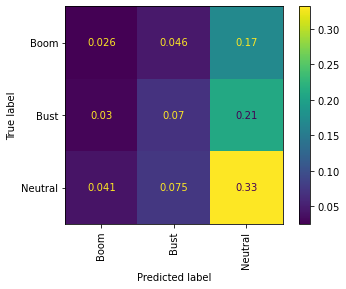

In [510]:
plot_confusion_matrix(base_pipe_rf, X_test, y_test, xticks_rotation='vertical', normalize='all');

### Hyper Parameter Tuning

In [511]:
hyper_pipe_rf = imbPipeline([('trans', trans),
                     ('smote', SMOTE(random_state=42)),
                     ('RF', RandomForestClassifier(random_state=42))])

hyper_pipe_lr = imbPipeline([('trans', trans),
                     ('smote', SMOTE(random_state=42)),
                     ('LR', LogisticRegression(random_state=42))])

In [512]:
#Random Forest hyperparameters
min_samples_split = [4,6,8]
n_estimators = [1000]

#Create grid
rf_param_grid = [{'RF__min_samples_split': min_samples_split,
                   'RF__n_estimators': n_estimators}]

#Random Forest hyperparameters
penalty = ['l1', 'l2']
C = np.logspace(-4, 4, 20)

#Create grid
lr_param_grid = [{'LR__penalty': penalty,
                   'LR__C': C}]

In [513]:
rf_grid_search = GridSearchCV(estimator=hyper_pipe_rf,
        param_grid=rf_param_grid,
        scoring='precision_macro',
        cv=2,
        n_jobs=-1)

lr_grid_search = GridSearchCV(estimator=hyper_pipe_lr,
        param_grid=lr_param_grid,
        scoring='precision_macro',
        cv=2,
        n_jobs=-1)

In [514]:
hyper_grids = [rf_grid_search, lr_grid_search]

In [515]:
hyper_grid_dict = {0: 'Random Forest', 1:'Logistic Regression'}

In [516]:
start = time.time()

for pipe in hyper_grids:
    pipe.fit(X_train,y_train)
    
end = time.time()
print('Time it took to run the fittings: {}'.format(round(end-start),0) + ' seconds')

Time it took to run the fittings: 84 seconds


In [517]:
for i, model in enumerate(hyper_grids):
    print('{} Validation Accuracy: {}'.format(hyper_grid_dict[i], model.score(X_test,y_test)))
    print('{} Best Params: {}'.format(hyper_grid_dict[i], model.best_params_))

Random Forest Validation Accuracy: 0.37999304769260395
Random Forest Best Params: {'RF__min_samples_split': 6, 'RF__n_estimators': 1000}
Logistic Regression Validation Accuracy: 0.38496089667683525
Logistic Regression Best Params: {'LR__C': 0.0018329807108324356, 'LR__penalty': 'l2'}


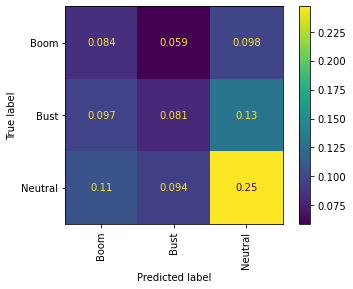

In [518]:
plot_confusion_matrix(lr_grid_search, X_test, y_test, xticks_rotation='vertical', normalize='all');

In [519]:
print(classification_report(y_test, rf_grid_search.predict(X_test)))

              precision    recall  f1-score   support

        Boom       0.29      0.19      0.23       642
        Bust       0.36      0.30      0.33       824
     Neutral       0.48      0.63      0.54      1191

    accuracy                           0.42      2657
   macro avg       0.38      0.37      0.37      2657
weighted avg       0.40      0.42      0.40      2657



In [520]:
current_projections

,Name,Team,Week,Opponent,Position,OPRNK,Projected,Salary,FPPG,line_close,over_under,team_proj,home_away,Dome
0,Derrick Henry,TEN,4,NYJ,RB,28.0,19.46,10200,24.7,-6.5,44.5,25.5,0.0,1.0
1,Ryan Tannehill,TEN,4,NYJ,QB,3.0,18.53,7500,17.0,-6.5,44.5,25.5,0.0,1.0
2,A.J. Brown,TEN,4,NYJ,WR,4.0,0.00,6800,7.1,-6.5,44.5,25.5,0.0,1.0
3,Julio Jones,TEN,4,NYJ,WR,4.0,0.00,6700,9.1,-6.5,44.5,25.5,0.0,1.0
4,Nick Westbrook-Ikhine,TEN,4,NYJ,WR,4.0,5.20,5300,3.8,-6.5,44.5,25.5,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,Keelan Cole,NYJ,4,TEN,WR,31.0,3.63,4500,1.0,6.5,44.5,19.0,1.0,1.0
309,Jeff Smith,NYJ,4,TEN,WR,31.0,0.00,4500,2.0,6.5,44.5,19.0,1.0,1.0
310,Trevon Wesco,NYJ,4,TEN,TE,1.0,0.44,4100,0.0,6.5,44.5,19.0,1.0,1.0
311,Ryan Griffin,NYJ,4,TEN,TE,1.0,2.88,4000,2.3,6.5,44.5,19.0,1.0,1.0


In [521]:
current_projections['Boom/Bust'] = lr_grid_search.predict(current_projections)

<ipython-input-521-96ea43941381>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_projections['Boom/Bust'] = lr_grid_search.predict(current_projections)


In [522]:
current_projections

,Name,Team,Week,Opponent,Position,OPRNK,Projected,Salary,FPPG,line_close,over_under,team_proj,home_away,Dome,Boom/Bust
0,Derrick Henry,TEN,4,NYJ,RB,28.0,19.46,10200,24.7,-6.5,44.5,25.5,0.0,1.0,Boom
1,Ryan Tannehill,TEN,4,NYJ,QB,3.0,18.53,7500,17.0,-6.5,44.5,25.5,0.0,1.0,Boom
2,A.J. Brown,TEN,4,NYJ,WR,4.0,0.00,6800,7.1,-6.5,44.5,25.5,0.0,1.0,Neutral
3,Julio Jones,TEN,4,NYJ,WR,4.0,0.00,6700,9.1,-6.5,44.5,25.5,0.0,1.0,Neutral
4,Nick Westbrook-Ikhine,TEN,4,NYJ,WR,4.0,5.20,5300,3.8,-6.5,44.5,25.5,0.0,1.0,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,Keelan Cole,NYJ,4,TEN,WR,31.0,3.63,4500,1.0,6.5,44.5,19.0,1.0,1.0,Neutral
309,Jeff Smith,NYJ,4,TEN,WR,31.0,0.00,4500,2.0,6.5,44.5,19.0,1.0,1.0,Neutral
310,Trevon Wesco,NYJ,4,TEN,TE,1.0,0.44,4100,0.0,6.5,44.5,19.0,1.0,1.0,Neutral
311,Ryan Griffin,NYJ,4,TEN,TE,1.0,2.88,4000,2.3,6.5,44.5,19.0,1.0,1.0,Neutral


In [523]:
current_projections = current_projections[['Name', 'Team', 'Boom/Bust']]

In [524]:
current_player_list = current_player_list.merge(current_projections, how ='left', on=['Name', 'Team'])

In [525]:
current_player_list

,Name,Position,Week,Team,OPRNK,FD_Projection,Salary,Percentage,Predictions,Boom/Bust
0,Derrick Henry,RB,4,TEN,28.0,19.46,10200,15.0,20.9,Boom
1,Dalvin Cook,RB,4,MIN,4.0,14.73,9500,12.0,14.7,NaN
2,Alvin Kamara,RB,4,NO,22.0,18.25,9000,22.0,20.1,Boom
3,Patrick Mahomes,QB,4,KC,9.0,24.55,8700,10.6,26.6,Boom
4,Cooper Kupp,WR,4,LAR,23.0,17.39,8600,24.1,17.3,Boom
...,...,...,...,...,...,...,...,...,...,...
657,New York Giants,DST,4,NYG,NaN,6.30,3400,4.0,6.3,NaN
658,Seattle Seahawks,DST,4,SEA,NaN,6.10,3300,4.0,6.1,NaN
659,Philadelphia Eagles,DST,4,PHI,NaN,4.40,3200,0.5,4.4,NaN
660,Houston Texans,DST,4,HOU,NaN,3.80,3100,0.5,3.8,NaN


In [526]:
current_player_list.to_csv('current_projections.csv')